# Geekbrains AI/BigData Python for Data Science course competition
https://www.kaggle.com/c/realestatepriceprediction/leaderboard

#### Files description
train.csv - the training set  
test.csv - the test set

#### Data fields
**Id** - идентификационный номер квартиры   
**DistrictId** - идентификационный номер района   
**Rooms** - количество комнат   
**Square** - площадь   
**LifeSquare** - жилая площадь   
**KitchenSquare** - площадь кухни   
**Floor** - этаж   
**HouseFloor** - количество этажей в доме   
**HouseYear** - год постройки дома   
**Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности   
**Social_1, Social_2, Social_3** - социальные показатели местности   
**Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья   
**Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров   
**Price** - цена квартиры

## Data EDA

#### Импорт библиотек

In [1]:
import os
import time
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.cluster import DBSCAN

import missingno as msno
import xgboost as xgb
import catboost as cb

import warnings
warnings.filterwarnings('ignore')

#### Функции

In [42]:
def get_input(data_path):
    '''
    Читаем данные из файла,
    приводим названия колонок к нижнему регистру, 
    выводим размеры датасетов
    '''
    data = pd.read_csv(data_path)
    data.columns = data.columns.str.lower()
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")
    return data


def get_numerical_features(df):
    """
    Список числовых признаков датасета
    """
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"Количество числовых признаков: {len(numerical_features)}")
    print(numerical_features)
    return numerical_features


def catboost_cross_validation(params, X, y, cv, categorical=None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")
    X[categorical] = X[categorical].astype(str)

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostRegressor(**params)
        model.fit(
            x_train, y_train, categorical,
            eval_set=[(x_train, y_train), (x_valid, y_valid)]
        )
        oof_preds[valid_idx] = model.predict(x_valid)
        score = r2_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 4)}")
        folds_scores.append(round(score, 4))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    print(f"{r2_score(y, oof_preds)}")
    return estimators, oof_preds

In [3]:
def prepare_dataset(X: pd.DataFrame, todrop: list, copy: bool=True) -> pd.DataFrame:
    """
    Выделение групп признаков, удаление выбросов, создание новых признаков.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков исходного датасета.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков, готовая к обучению/предикту.

    """
    if copy:
        X = X.copy()

    target = 'price'
    
    X = X.drop(columns=todrop)
    
    # Списки признаков
    num_feats = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_feats = X.select_dtypes(include=[np.object]).columns.tolist()
    discr_feats = [feature for feature in num_feats if len(X[feature].unique()) < 25] + ["districtid"]
    X[discr_feats] = X[discr_feats].astype(np.int)
    
    X.loc[X['rooms'] == 0, 'rooms'] = 2
    X.loc[X['rooms'] > 5, 'rooms'] = 2
    X.loc[X['floor'] > 50, 'floor'] = X['floor'].median()
    X.loc[X['lifesquare'] > 1000, 'lifesquare'] = X.loc[X['lifesquare'] > 1000, 'lifesquare'] / 100
    X.loc[X['lifesquare'] > 250, 'lifesquare'] = X.loc[X['lifesquare'] > 250, 'lifesquare'] / 10
    X.loc[X['lifesquare'] > 250, 'lifesquare'] = X['lifesquare'].median()
    X.loc[X['kitchensquare'] > 50, 'kitchensquare'] = X['kitchensquare'].median()
    X.loc[X['housefloor'] > 50, 'housefloor'] = X['housefloor'].median()
    X['squ_rooms'] = X['square'] / X['rooms']
    X['squ_kitch'] = X['square'] - X['kitchensquare']

    return X


#### Загрузка данных

In [4]:
path = 'data'
os.listdir(path)

['test.csv', 'train.csv']

In [5]:
train = get_input(f'{path}/train.csv')
test = get_input(f'{path}/test.csv')

data/train.csv: shape = 10000 rows, 20 cols
data/test.csv: shape = 5000 rows, 19 cols


In [6]:
train.head(2)

,id,districtid,rooms,square,lifesquare,kitchensquare,floor,housefloor,houseyear,ecology_1,ecology_2,ecology_3,social_1,social_2,social_3,healthcare_1,helthcare_2,shops_1,shops_2,price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.08904,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.00007,B,B,46,10309,1,240.0,1,16,B,300009.450063


In [7]:
test.head(2)

,id,districtid,rooms,square,lifesquare,kitchensquare,floor,housefloor,houseyear,ecology_1,ecology_2,ecology_3,social_1,social_2,social_3,healthcare_1,helthcare_2,shops_1,shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B


#### Основные статистики

In [8]:
train.describe()

,id,districtid,rooms,square,lifesquare,kitchensquare,floor,housefloor,houseyear,ecology_1,social_1,social_2,social_3,healthcare_1,helthcare_2,shops_1,price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [9]:
test.describe()

,id,districtid,rooms,square,lifesquare,kitchensquare,floor,housefloor,houseyear,ecology_1,social_1,social_2,social_3,healthcare_1,helthcare_2,shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


### Анализ числовых признаков

In [10]:
numerical_features = get_numerical_features(train)

Количество числовых признаков: 17
['id', 'districtid', 'rooms', 'square', 'lifesquare', 'kitchensquare', 'floor', 'housefloor', 'houseyear', 'ecology_1', 'social_1', 'social_2', 'social_3', 'healthcare_1', 'helthcare_2', 'shops_1', 'price']


#### Выделим целевую переменную

In [11]:
target = 'price'

In [12]:
numerical_features = list(set(numerical_features) - set([target, 'id']))

#### Плотность распределения целевой переменной

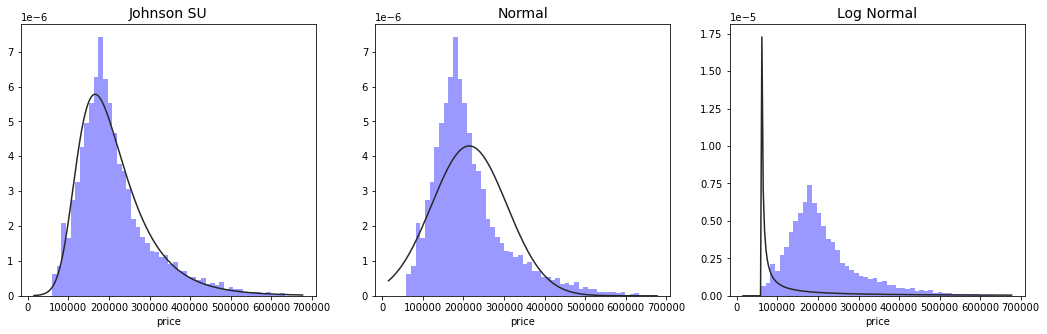

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].set_title("Johnson SU", fontsize=14)
sns.distplot(train[target], kde=False, color="blue", fit=st.johnsonsu, ax=axes[0])

axes[1].set_title("Normal", fontsize=14)
sns.distplot(train[target], kde=False, color="blue", fit=st.norm, ax=axes[1])

axes[2].set_title("Log Normal", fontsize=14)
sns.distplot(train[target], kde=False, color="blue", fit=st.lognorm, ax=axes[2])
plt.show()

#### Переменные, связанные со временем

In [14]:
print(f'уникальных значений: {train["houseyear"].nunique()}')
train['houseyear'].unique()

уникальных значений: 97


array([    1969,     1978,     1968,     1977,     1976,     2011,
           1960,     2014,     1973,     1959,     1999,     1980,
           1979,     1983,     2001,     2012,     2002,     1996,
           1964,     2018,     1972,     1965,     1984,     1961,
           1971,     1963,     2017,     1970,     1981,     2003,
           2016,     1991,     1975,     2006,     2009,     1985,
           1974,     1994,     2000,     1987,     1998,     2005,
           1990,     1982,     1997,     2015,     2008,     2010,
           2004,     2007,     1967,     1957,     1962,     1993,
           1966,     1955,     1937,     1992,     1954,     1995,
           2019,     1948,     1986,     2013,     1989,     1958,
           1938,     1956,     1988,     2020,     1951,     1952,
           1935,     1914,     1932,     1950,     1917,     1918,
           1940, 20052011,     1942,     1939,     1934,     1931,
           1919,     1912,     1953,     1936,     1947,     1

In [15]:
print(f'уникальных значений: {test["houseyear"].nunique()}')
test['houseyear'].unique()

уникальных значений: 97


array([1972, 1977, 1909, 2007, 2017, 1997, 2014, 1981, 1971, 1968, 1974,
       1959, 1976, 2015, 2004, 2000, 1970, 1964, 1975, 1988, 1963, 1987,
       1933, 1962, 1969, 1984, 1980, 1929, 1990, 1960, 2016, 1954, 1996,
       2019, 1993, 1911, 1985, 1982, 1966, 1978, 2003, 1983, 1973, 2018,
       2013, 2010, 1957, 1958, 1965, 2008, 1986, 1979, 2012, 1995, 1999,
       1989, 1992, 2009, 1956, 2005, 1998, 1940, 2002, 1991, 1967, 1994,
       2020, 1955, 1961, 2006, 2011, 1926, 2001, 1934, 1917, 1931, 1953,
       1943, 1941, 1930, 1912, 1935, 1927, 1937, 1918, 1950, 1952, 1910,
       1939, 1914, 1908, 1938, 1928, 1932, 1948, 1949, 1920], dtype=int64)

In [16]:
set(train['houseyear'].unique()) - set(test['houseyear'].unique())

{1916, 1919, 1936, 1942, 1947, 1951, 4968, 20052011}

In [17]:
set(test['houseyear'].unique()) - set(train['houseyear'].unique())

{1908, 1909, 1911, 1920, 1926, 1927, 1943, 1949}

4968, 20052011 - это явные опечатки, исправим их

In [18]:
train.loc[train["houseyear"] == 4968, 'houseyear'] = 1968
train.loc[train["houseyear"] == 20052011, 'houseyear'] = 2005

Text(0.5, 0, 'houseyear')

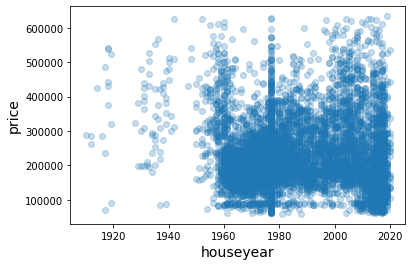

In [19]:
plt.scatter(x=train["houseyear"], y=train["price"], alpha=0.25)
plt.ylabel("price", size=14)
plt.xlabel("houseyear", size=14)

Явной зависимости стоимости жилья от гда постройки не наблюдается.

#### Дискретные признаки

In [20]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<25 
] + ["districtid"]

print(f"Discrete Variables Count: {len(discrete_feature)}")
discrete_feature

Discrete Variables Count: 4


['shops_1', 'helthcare_2', 'rooms', 'districtid']

In [21]:
train[discrete_feature] = train[discrete_feature].astype('int')
test[discrete_feature] = test[discrete_feature].astype('int')

#### Категориальные признаки

In [22]:
categorical_features = train.select_dtypes(include=[np.object]).columns.tolist()
print(f"Categorical Feature Count {len(categorical_features)}")
categorical_features

Categorical Feature Count 3


['ecology_2', 'ecology_3', 'shops_2']

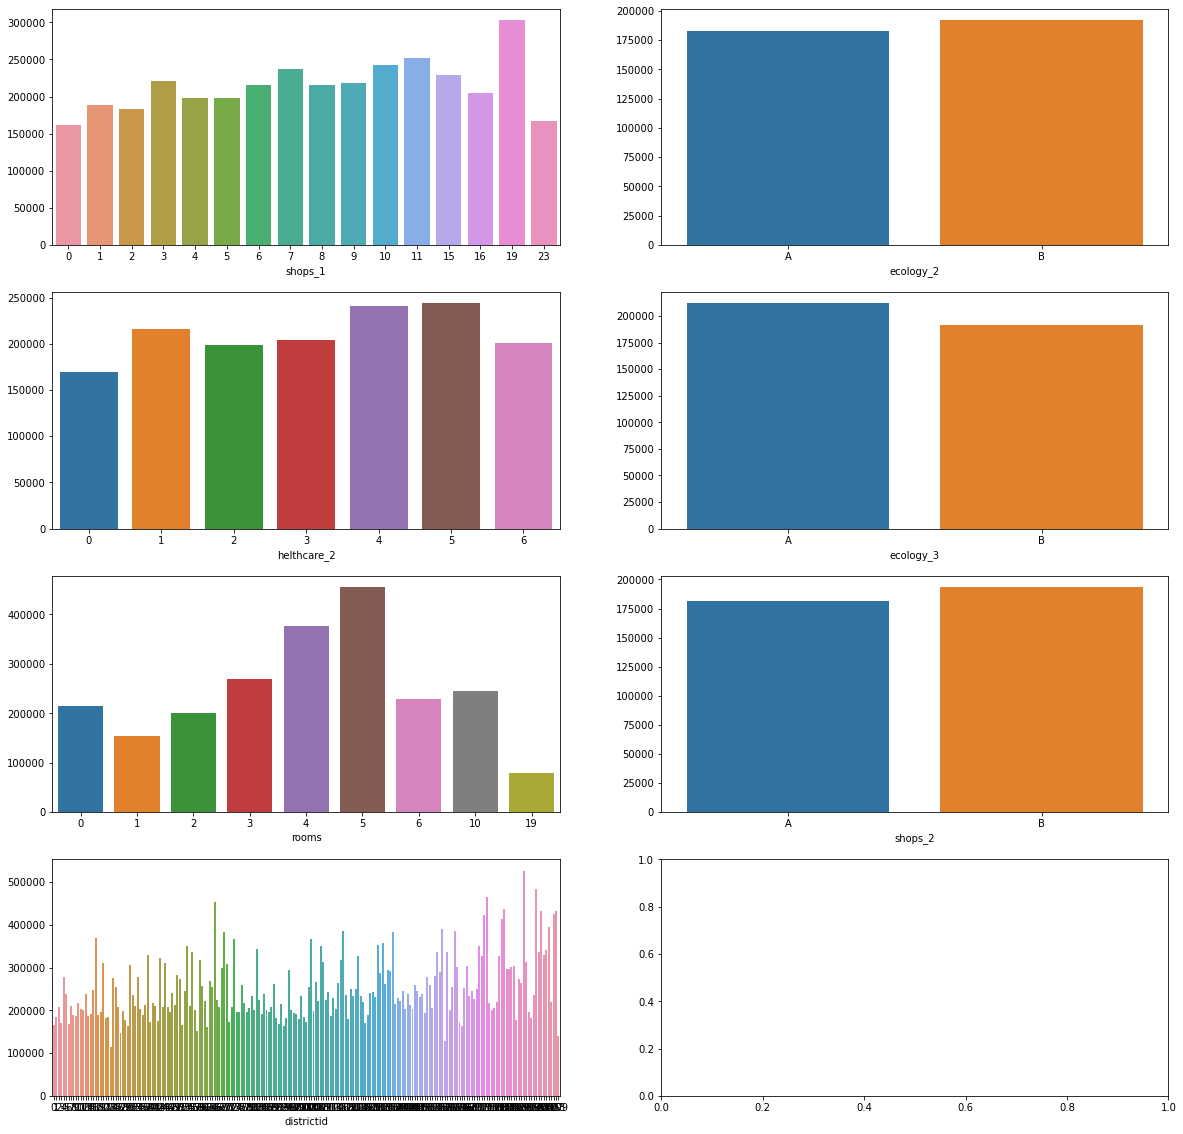

In [23]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

for num, feature in enumerate(discrete_feature + categorical_features):
    data = train.copy()
    statistics = data.groupby([feature])["price"].median()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        ax=axes[num%4, num//4]
    )

Стоимость жилья растет с увеличением количества комнат до пяти, потом цена слишком резко папает, чтобы быть правдой.

Так же стоимость зависит от района.

#### Непрерывные признаки

In [24]:
continuous_feature = [
    feature for feature in numerical_features
    if feature not in discrete_feature + ['houseyear']]

print(f"Continuous Feature Count {len(continuous_feature)}")
continuous_feature

Continuous Feature Count 10


['social_2',
 'social_3',
 'healthcare_1',
 'kitchensquare',
 'ecology_1',
 'lifesquare',
 'square',
 'housefloor',
 'floor',
 'social_1']

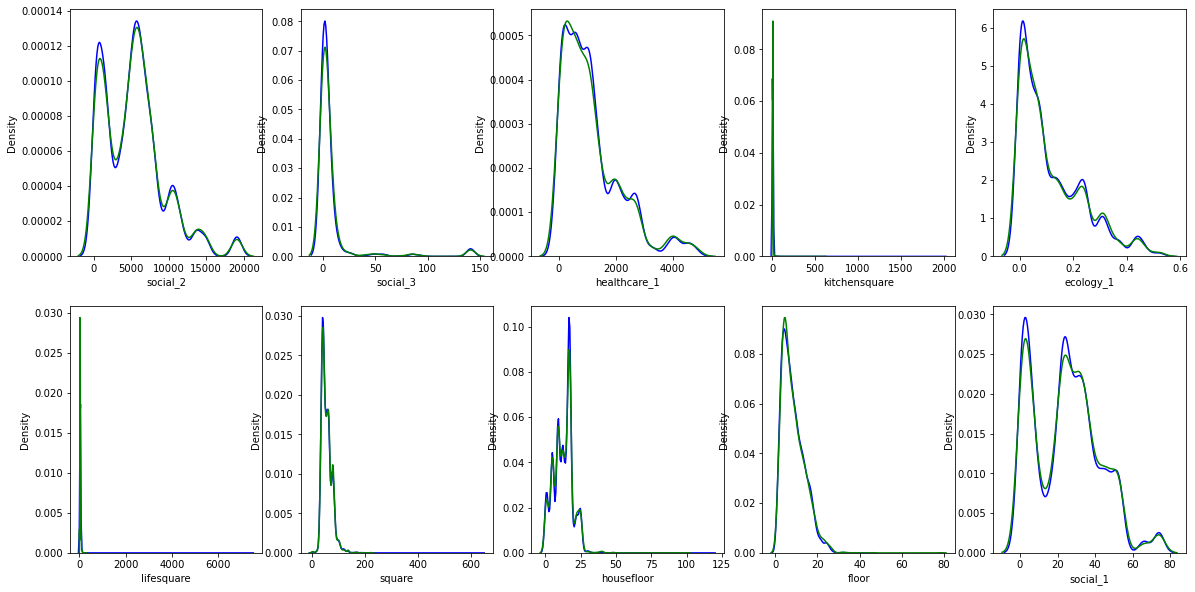

In [25]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for num, feature in enumerate(continuous_feature):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//5, num%5], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//5, num%5], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//5, num%5], color="blue", label="train")

### Анализ пропусков

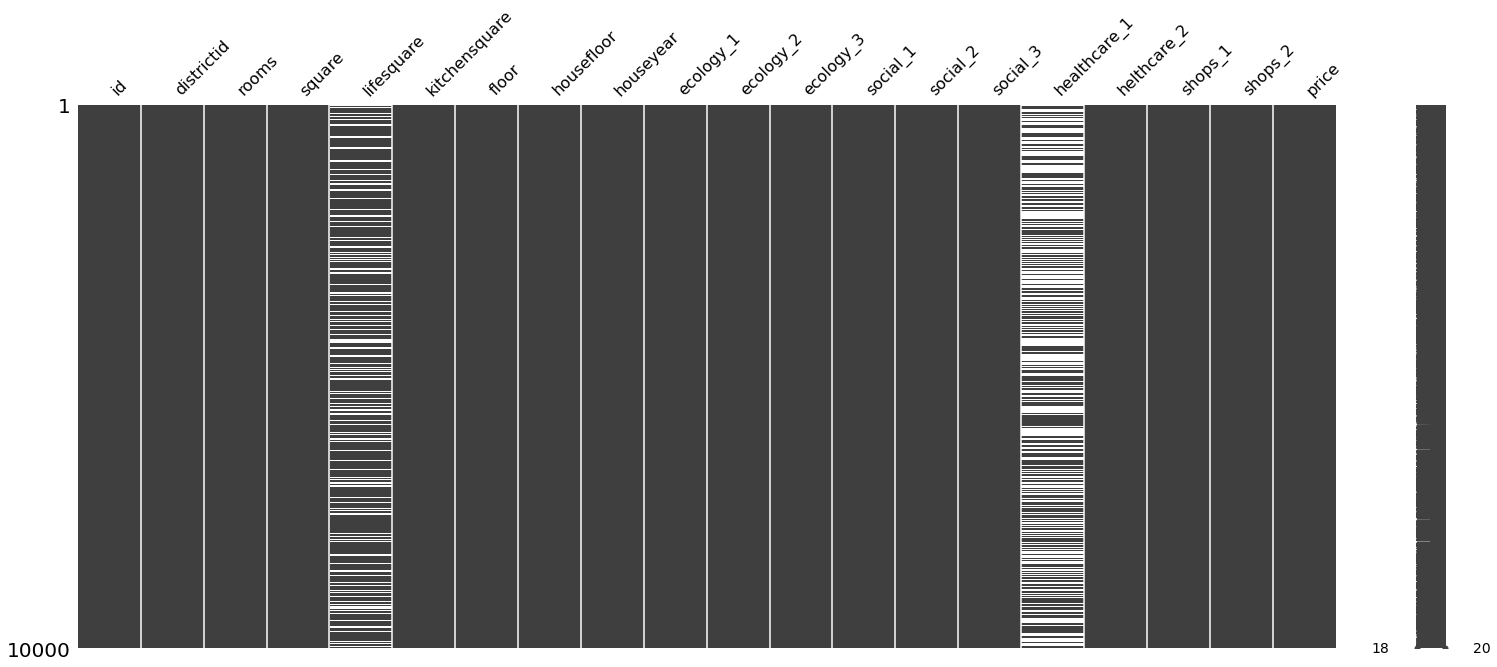

In [26]:
msno.matrix(train);

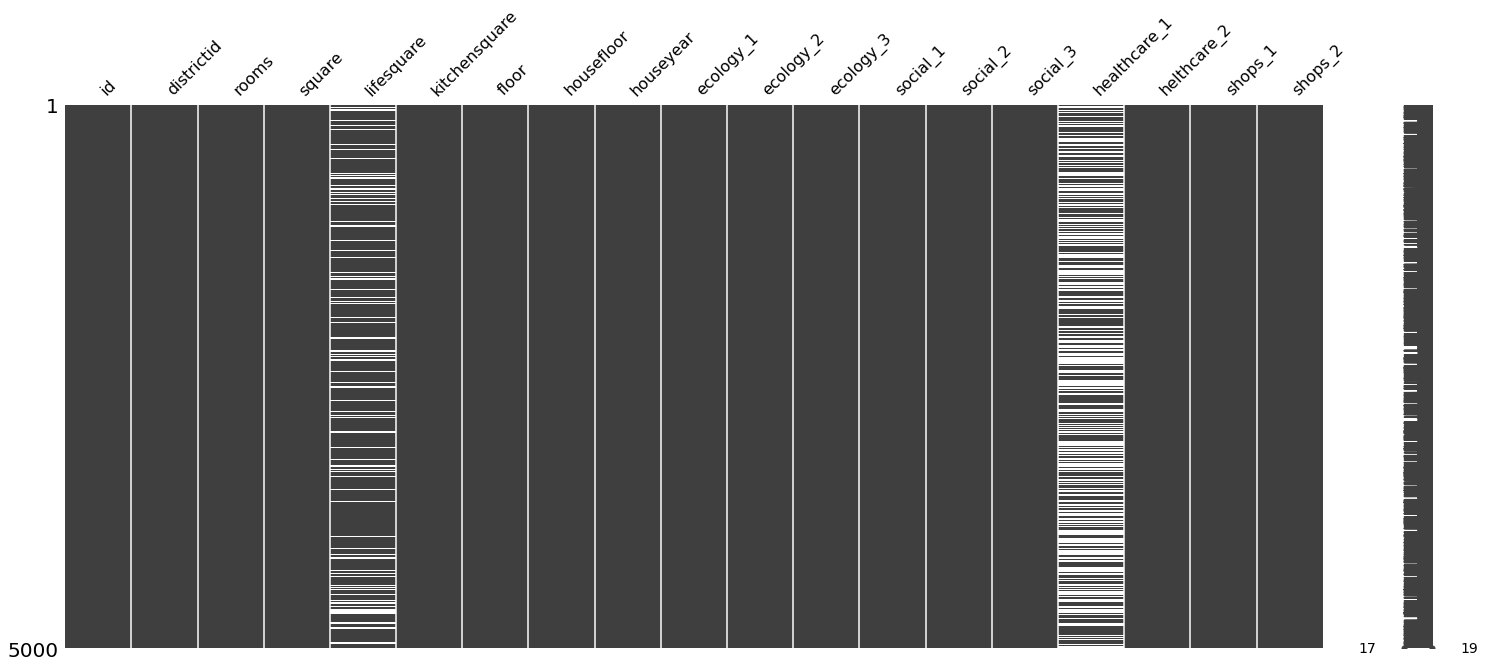

In [27]:
msno.matrix(test);

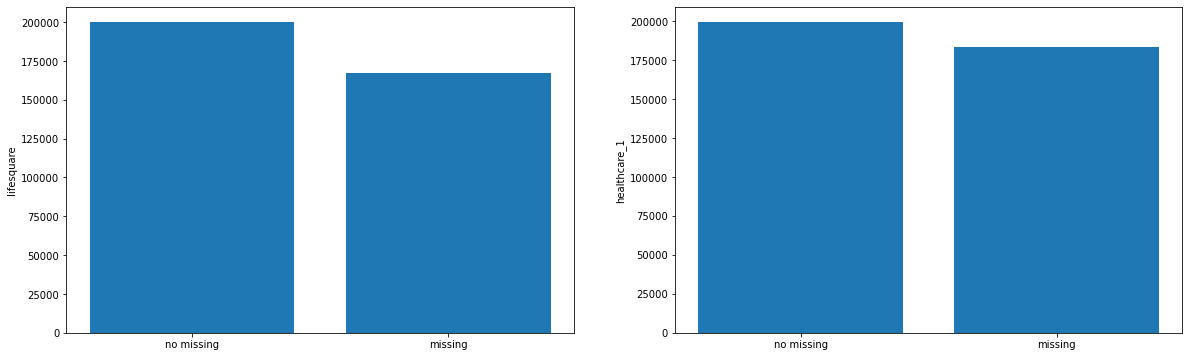

In [28]:
features_with_na = [
    feature for feature in train.columns
    if train[feature].isnull().sum() > 1]

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
for num, feature in enumerate(features_with_na):
    data = train.copy()
    data[feature] = np.where(data[feature].isnull(), 1, 0)
    statistics = data.groupby(feature)["price"].median()
    axes[num//1].bar(statistics.index, statistics.values)
    axes[num//1].set_xticks([0, 1])
    axes[num//1].set_xticklabels(["no missing", "missing"])
    axes[num//1].set_ylabel(feature)

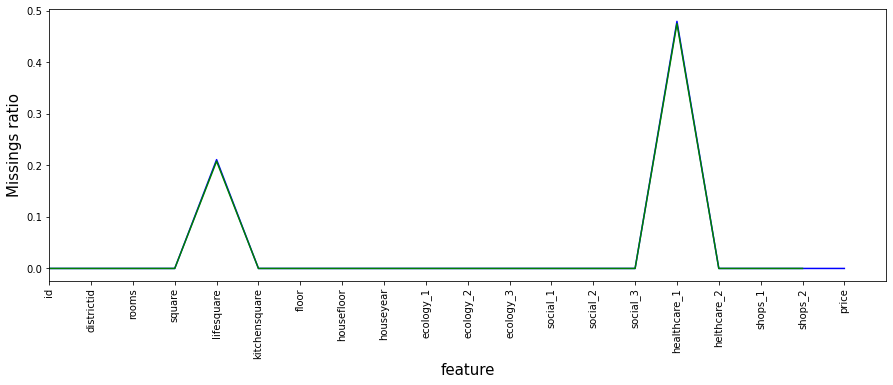

In [29]:
fig = plt.figure(figsize=(15, 5))
plt.plot(train.isnull().mean(), label="train", color="blue")
plt.plot(test.isnull().mean(), label="test", color="green")
plt.xticks(range(train.shape[1]), train.columns, rotation=90)
plt.ylabel("Missings ratio", size=15)
plt.xlabel("feature", size=15)
plt.xlim(0, train.shape[1])
plt.show()

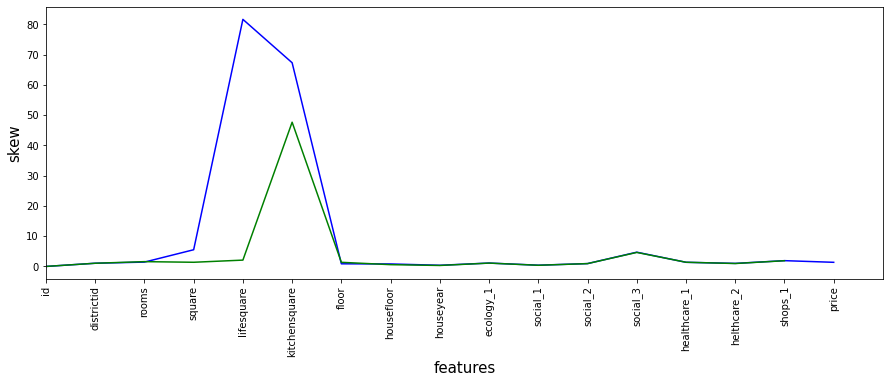

In [30]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = train.skew(), test.skew()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.xlim(0, len(train_stats))
plt.ylabel("skew", size=15)
plt.show()

Все признаки, кроме площади, жилой площади, площади кухни, года и social_3 имеют скошенное распределение.

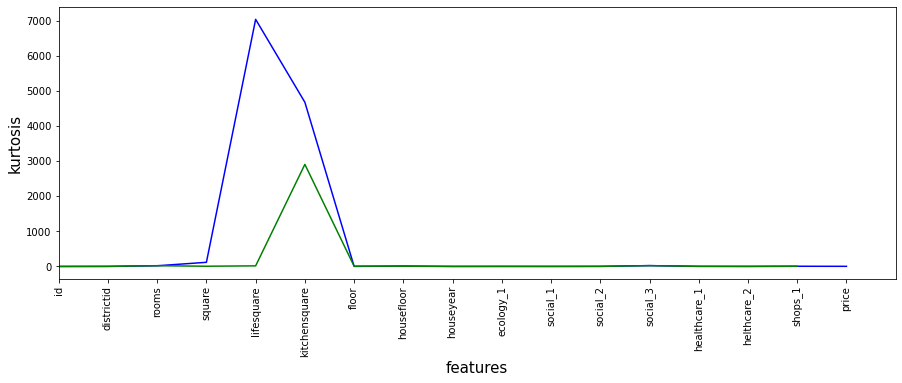

In [31]:
fig = plt.figure(figsize=(15, 5))
train_stats, test_stats = train.kurtosis(), test.kurtosis()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.ylabel("kurtosis", size=15)
plt.xlim(0, len(train_stats))
plt.show()

#### Линейные связи

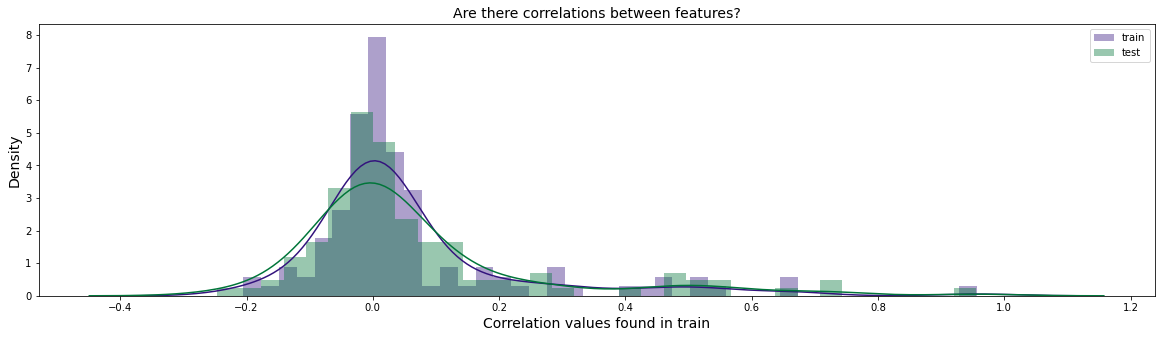

In [32]:
train_correlations = train.drop([target], axis=1).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="#33137d", label="train")
sns.distplot(test_correlations, color="#007539", label="test")
plt.title("Are there correlations between features?", size=14)
plt.xlabel("Correlation values found in train", size=14)
plt.ylabel("Density", size=14)
plt.legend()
plt.show()

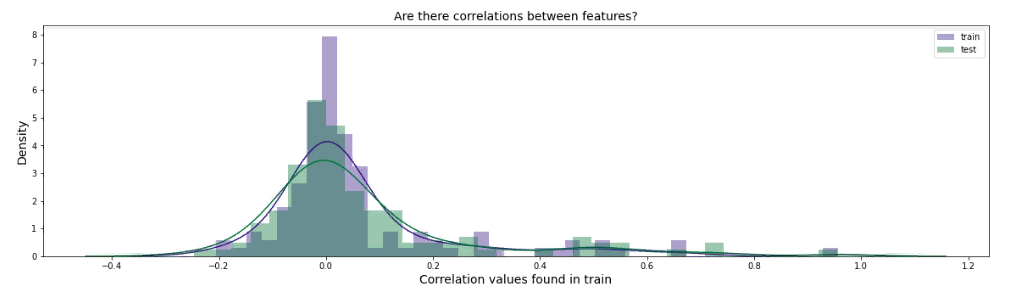

### Связь между признаками

In [33]:
X_train = train.fillna(0)
X_train = pd.get_dummies(X_train)
X_test = test.fillna(0)
X_test = pd.get_dummies(X_test)

#### Нелинейные связи

In [34]:
parameters = {
    "max_depth": [6, 8, 10, 15],
    "min_samples_leaf": [15, 25, 50, 100, 250]
}

model = RandomForestRegressor(
    n_estimators=100, n_jobs=6, random_state=27
)
grid = GridSearchCV(
    model,
    parameters,
    n_jobs=-1,
    verbose=2,
    cv=3,
)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   14.0s finished


Wall time: 15 s


Text(0.5, 1.0, 'What are the top important features to start with?')

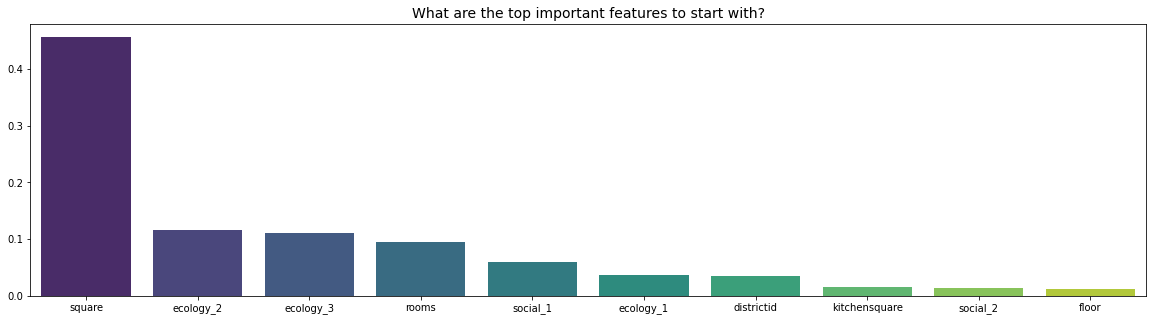

In [35]:
%%time
grid.fit(
    X_train.drop([target, 'id'], axis=1),
    X_train[target]
)

ntop = 10
importances = grid.best_estimator_.feature_importances_
idx = np.argsort(importances)[::-1][0:ntop]
feature_names = train.drop([target, 'id'], axis=1).columns.values

plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

### Анализ распределения признаков на обучении и на тесте

In [36]:
x_adv = pd.concat([
    X_train.drop(target, axis=1), X_test
])
x_adv = x_adv.reset_index(drop=True)
x_adv = x_adv.drop("id", axis=1)

y_adv = np.hstack((
    np.zeros(X_train.shape[0]),
    np.ones(X_test.shape[0])
))

cv_ = cross_val_score(
    estimator=xgb.XGBClassifier(n_estimators=25),
    X=x_adv, y=y_adv, cv=5, scoring="roc_auc"
)

print(f"CV-mean: {round(np.mean(cv_), 4)} +/- {round(np.std(cv_), 3)}")

CV-mean: 0.5017 +/- 0.005


Распределения признаков похожи.   
CV-mean: 0.5017 +/- 0.005

### Добавление признаков

In [37]:
# Кластеризуем обучающую и тестовую выборки
train_x = train[numerical_features]
test_x = test[numerical_features]
joined_df = pd.concat([train_x, test_x])
joined_df = joined_df.fillna(0)
clustering = DBSCAN(eps=70, min_samples=60).fit_predict(joined_df)
train['clustering'] = clustering[train.index]
test['clustering'] = clustering[test.index]

# Добавим среднюю цену по districtid
target_median = train[target].median()
price_districtid = train.groupby('districtid').agg({target: 'median'}).rename(
        columns={'price': 'price_districtid'})
train = train.merge(price_districtid, how='left', on='districtid')
test = test.merge(price_districtid, how='left', on='districtid')

price_floor = train.groupby('floor').agg({target: 'median'}).rename(
        columns={'price': 'price_floor'})
train = train.merge(price_floor, how='left', on='floor')
test = test.merge(price_floor, how='left', on='floor')

# price_rooms = train.groupby('rooms').agg({target: 'median'}).rename(
#         columns={'price': 'price_rooms'})
# train = train.merge(price_rooms, how='left', on='rooms')
# test = test.merge(price_rooms, how='left', on='rooms')

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 23 columns):
id                  10000 non-null int64
districtid          10000 non-null int32
rooms               10000 non-null int32
square              10000 non-null float64
lifesquare          7887 non-null float64
kitchensquare       10000 non-null float64
floor               10000 non-null int64
housefloor          10000 non-null float64
houseyear           10000 non-null int64
ecology_1           10000 non-null float64
ecology_2           10000 non-null object
ecology_3           10000 non-null object
social_1            10000 non-null int64
social_2            10000 non-null int64
social_3            10000 non-null int64
healthcare_1        5202 non-null float64
helthcare_2         10000 non-null int32
shops_1             10000 non-null int32
shops_2             10000 non-null object
price               10000 non-null float64
clustering          10000 non-null int64
price_districtid

### Обработка датасетов, удаление выбросов, добавление новых признаков

In [39]:
todrop = [target, 'id']
X_train = prepare_dataset(train, todrop)
y_train = train[target]
X_test = prepare_dataset(test, ['id'])

## Обучение модели

In [51]:
cb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "loss_function": "RMSE",
    "eval_metric": "R2",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 10,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27
}

cv = KFold(n_splits=7, random_state=27, shuffle=True)

In [52]:
model = catboost_cross_validation(cb_params, X_train, y_train, cv, categorical_features)

Sat Nov 14 23:35:58 2020, Cross-Validation, 10000 rows, 23 cols
0:	learn: 0.0112810	test: 0.0112810	test1: 0.0103804	best: 0.0103804 (0)	total: 4.68ms	remaining: 9.36s
10:	learn: 0.1156609	test: 0.1156609	test1: 0.1148387	best: 0.1148387 (10)	total: 28ms	remaining: 5.07s
20:	learn: 0.2034156	test: 0.2034156	test1: 0.2018820	best: 0.2018820 (20)	total: 45.8ms	remaining: 4.32s
30:	learn: 0.2760874	test: 0.2760874	test1: 0.2732320	best: 0.2732320 (30)	total: 62.4ms	remaining: 3.96s
40:	learn: 0.3396883	test: 0.3396883	test1: 0.3362890	best: 0.3362890 (40)	total: 78.3ms	remaining: 3.74s
50:	learn: 0.3918911	test: 0.3918911	test1: 0.3878241	best: 0.3878241 (50)	total: 94.8ms	remaining: 3.62s
60:	learn: 0.4367552	test: 0.4367552	test1: 0.4315657	best: 0.4315657 (60)	total: 110ms	remaining: 3.51s
70:	learn: 0.4749784	test: 0.4749784	test1: 0.4685648	best: 0.4685648 (70)	total: 126ms	remaining: 3.42s
80:	learn: 0.5072370	test: 0.5072370	test1: 0.5003280	best: 0.5003280 (80)	total: 141ms	remain

840:	learn: 0.7751717	test: 0.7751717	test1: 0.7350964	best: 0.7350964 (840)	total: 1.28s	remaining: 1.76s
850:	learn: 0.7757635	test: 0.7757635	test1: 0.7353910	best: 0.7353910 (850)	total: 1.29s	remaining: 1.75s
860:	learn: 0.7763343	test: 0.7763343	test1: 0.7356697	best: 0.7356697 (860)	total: 1.31s	remaining: 1.73s
870:	learn: 0.7768885	test: 0.7768885	test1: 0.7358958	best: 0.7358958 (870)	total: 1.32s	remaining: 1.71s
880:	learn: 0.7775396	test: 0.7775396	test1: 0.7360813	best: 0.7360813 (880)	total: 1.34s	remaining: 1.7s
890:	learn: 0.7780839	test: 0.7780839	test1: 0.7363840	best: 0.7363840 (890)	total: 1.35s	remaining: 1.68s
900:	learn: 0.7785798	test: 0.7785798	test1: 0.7367214	best: 0.7367214 (900)	total: 1.37s	remaining: 1.67s
910:	learn: 0.7793643	test: 0.7793643	test1: 0.7371327	best: 0.7371395 (909)	total: 1.38s	remaining: 1.65s
920:	learn: 0.7800123	test: 0.7800123	test1: 0.7375036	best: 0.7375036 (920)	total: 1.4s	remaining: 1.64s
930:	learn: 0.7806041	test: 0.7806041	t

1630:	learn: 0.8129716	test: 0.8129716	test1: 0.7515547	best: 0.7515547 (1630)	total: 2.52s	remaining: 570ms
1640:	learn: 0.8132907	test: 0.8132907	test1: 0.7515287	best: 0.7515599 (1631)	total: 2.53s	remaining: 554ms
1650:	learn: 0.8136384	test: 0.8136384	test1: 0.7515815	best: 0.7515872 (1643)	total: 2.55s	remaining: 538ms
1660:	learn: 0.8139044	test: 0.8139044	test1: 0.7516353	best: 0.7516394 (1657)	total: 2.56s	remaining: 523ms
1670:	learn: 0.8141985	test: 0.8141985	test1: 0.7517667	best: 0.7517667 (1670)	total: 2.58s	remaining: 507ms
1680:	learn: 0.8144757	test: 0.8144757	test1: 0.7518941	best: 0.7518941 (1680)	total: 2.59s	remaining: 492ms
1690:	learn: 0.8146916	test: 0.8146916	test1: 0.7518312	best: 0.7518948 (1684)	total: 2.61s	remaining: 477ms
1700:	learn: 0.8149341	test: 0.8149341	test1: 0.7518950	best: 0.7518950 (1700)	total: 2.62s	remaining: 461ms
1710:	learn: 0.8152733	test: 0.8152733	test1: 0.7520456	best: 0.7520466 (1709)	total: 2.64s	remaining: 446ms
1720:	learn: 0.8154

420:	learn: 0.7345266	test: 0.7345266	test1: 0.7411012	best: 0.7411012 (420)	total: 640ms	remaining: 2.4s
430:	learn: 0.7359125	test: 0.7359125	test1: 0.7422728	best: 0.7422728 (430)	total: 655ms	remaining: 2.38s
440:	learn: 0.7371112	test: 0.7371112	test1: 0.7431178	best: 0.7431178 (440)	total: 669ms	remaining: 2.37s
450:	learn: 0.7383747	test: 0.7383747	test1: 0.7442700	best: 0.7442700 (450)	total: 684ms	remaining: 2.35s
460:	learn: 0.7397089	test: 0.7397089	test1: 0.7452590	best: 0.7452590 (460)	total: 699ms	remaining: 2.33s
470:	learn: 0.7407876	test: 0.7407876	test1: 0.7460780	best: 0.7460780 (470)	total: 713ms	remaining: 2.31s
480:	learn: 0.7418859	test: 0.7418859	test1: 0.7469263	best: 0.7469263 (480)	total: 728ms	remaining: 2.3s
490:	learn: 0.7429842	test: 0.7429842	test1: 0.7477367	best: 0.7477367 (490)	total: 742ms	remaining: 2.28s
500:	learn: 0.7441681	test: 0.7441681	test1: 0.7486205	best: 0.7486205 (500)	total: 757ms	remaining: 2.26s
510:	learn: 0.7451569	test: 0.7451569	t

1260:	learn: 0.7929277	test: 0.7929277	test1: 0.7751650	best: 0.7751650 (1260)	total: 1.87s	remaining: 1.1s
1270:	learn: 0.7933494	test: 0.7933494	test1: 0.7753465	best: 0.7753465 (1270)	total: 1.89s	remaining: 1.08s
1280:	learn: 0.7937687	test: 0.7937687	test1: 0.7754726	best: 0.7754726 (1280)	total: 1.9s	remaining: 1.07s
1290:	learn: 0.7942213	test: 0.7942213	test1: 0.7755867	best: 0.7755877 (1289)	total: 1.92s	remaining: 1.05s
1300:	learn: 0.7947021	test: 0.7947021	test1: 0.7758231	best: 0.7758231 (1300)	total: 1.93s	remaining: 1.04s
1310:	learn: 0.7951815	test: 0.7951815	test1: 0.7758974	best: 0.7758974 (1310)	total: 1.95s	remaining: 1.02s
1320:	learn: 0.7956802	test: 0.7956802	test1: 0.7760578	best: 0.7760578 (1320)	total: 1.96s	remaining: 1.01s
1330:	learn: 0.7961427	test: 0.7961427	test1: 0.7761352	best: 0.7761352 (1330)	total: 1.97s	remaining: 993ms
1340:	learn: 0.7965480	test: 0.7965480	test1: 0.7763437	best: 0.7763437 (1340)	total: 1.99s	remaining: 978ms
1350:	learn: 0.796943

Fold 2, Valid score = 0.783
0:	learn: 0.0110023	test: 0.0110023	test1: 0.0087845	best: 0.0087845 (0)	total: 4.94ms	remaining: 9.87s
10:	learn: 0.1154920	test: 0.1154920	test1: 0.1103018	best: 0.1103018 (10)	total: 28.4ms	remaining: 5.14s
20:	learn: 0.2042411	test: 0.2042411	test1: 0.1970373	best: 0.1970373 (20)	total: 44.9ms	remaining: 4.23s
30:	learn: 0.2769437	test: 0.2769437	test1: 0.2683983	best: 0.2683983 (30)	total: 62.4ms	remaining: 3.96s
40:	learn: 0.3399564	test: 0.3399564	test1: 0.3297955	best: 0.3297955 (40)	total: 78.3ms	remaining: 3.74s
50:	learn: 0.3923273	test: 0.3923273	test1: 0.3811099	best: 0.3811099 (50)	total: 94ms	remaining: 3.59s
60:	learn: 0.4369996	test: 0.4369996	test1: 0.4254050	best: 0.4254050 (60)	total: 110ms	remaining: 3.49s
70:	learn: 0.4750206	test: 0.4750206	test1: 0.4625337	best: 0.4625337 (70)	total: 126ms	remaining: 3.41s
80:	learn: 0.5074314	test: 0.5074314	test1: 0.4944349	best: 0.4944349 (80)	total: 141ms	remaining: 3.34s
90:	learn: 0.5353236	test

870:	learn: 0.7781623	test: 0.7781623	test1: 0.7342626	best: 0.7342626 (870)	total: 1.31s	remaining: 1.7s
880:	learn: 0.7788955	test: 0.7788955	test1: 0.7345681	best: 0.7345681 (880)	total: 1.32s	remaining: 1.68s
890:	learn: 0.7794751	test: 0.7794751	test1: 0.7347580	best: 0.7347580 (890)	total: 1.34s	remaining: 1.67s
900:	learn: 0.7801162	test: 0.7801162	test1: 0.7350878	best: 0.7350878 (900)	total: 1.35s	remaining: 1.65s
910:	learn: 0.7807832	test: 0.7807832	test1: 0.7352294	best: 0.7352294 (910)	total: 1.37s	remaining: 1.64s
920:	learn: 0.7813510	test: 0.7813510	test1: 0.7355109	best: 0.7355109 (920)	total: 1.38s	remaining: 1.62s
930:	learn: 0.7819207	test: 0.7819207	test1: 0.7357341	best: 0.7357341 (930)	total: 1.4s	remaining: 1.6s
940:	learn: 0.7824678	test: 0.7824678	test1: 0.7360186	best: 0.7360241 (939)	total: 1.41s	remaining: 1.59s
950:	learn: 0.7830912	test: 0.7830912	test1: 0.7362650	best: 0.7362650 (950)	total: 1.43s	remaining: 1.57s
960:	learn: 0.7836528	test: 0.7836528	te

1700:	learn: 0.8162381	test: 0.8162381	test1: 0.7439115	best: 0.7439115 (1700)	total: 2.55s	remaining: 448ms
1710:	learn: 0.8166477	test: 0.8166477	test1: 0.7439096	best: 0.7439115 (1700)	total: 2.56s	remaining: 433ms
1720:	learn: 0.8169812	test: 0.8169812	test1: 0.7439447	best: 0.7439554 (1719)	total: 2.58s	remaining: 418ms
1730:	learn: 0.8174159	test: 0.8174159	test1: 0.7439932	best: 0.7440235 (1729)	total: 2.6s	remaining: 403ms
1740:	learn: 0.8178417	test: 0.8178417	test1: 0.7440660	best: 0.7440660 (1740)	total: 2.61s	remaining: 388ms
1750:	learn: 0.8181571	test: 0.8181571	test1: 0.7441040	best: 0.7441040 (1750)	total: 2.63s	remaining: 373ms
1760:	learn: 0.8185200	test: 0.8185200	test1: 0.7441845	best: 0.7441845 (1760)	total: 2.64s	remaining: 358ms
1770:	learn: 0.8188580	test: 0.8188580	test1: 0.7442069	best: 0.7442426 (1768)	total: 2.66s	remaining: 343ms
1780:	learn: 0.8192478	test: 0.8192478	test1: 0.7443316	best: 0.7443316 (1780)	total: 2.67s	remaining: 328ms
1790:	learn: 0.81955

510:	learn: 0.7555992	test: 0.7555992	test1: 0.6960615	best: 0.6960615 (510)	total: 808ms	remaining: 2.35s
520:	learn: 0.7566015	test: 0.7566015	test1: 0.6965827	best: 0.6965827 (520)	total: 823ms	remaining: 2.34s
530:	learn: 0.7574811	test: 0.7574811	test1: 0.6971201	best: 0.6971201 (530)	total: 839ms	remaining: 2.32s
540:	learn: 0.7583500	test: 0.7583500	test1: 0.6977416	best: 0.6977416 (540)	total: 853ms	remaining: 2.3s
550:	learn: 0.7592060	test: 0.7592060	test1: 0.6981322	best: 0.6981322 (550)	total: 868ms	remaining: 2.28s
560:	learn: 0.7602416	test: 0.7602416	test1: 0.6986030	best: 0.6986034 (559)	total: 882ms	remaining: 2.26s
570:	learn: 0.7611317	test: 0.7611317	test1: 0.6991068	best: 0.6991068 (570)	total: 897ms	remaining: 2.24s
580:	learn: 0.7620286	test: 0.7620286	test1: 0.6996072	best: 0.6996072 (580)	total: 912ms	remaining: 2.23s
590:	learn: 0.7628865	test: 0.7628865	test1: 0.7000833	best: 0.7000833 (590)	total: 926ms	remaining: 2.21s
600:	learn: 0.7636935	test: 0.7636935	

1350:	learn: 0.8060158	test: 0.8060158	test1: 0.7155872	best: 0.7155939 (1349)	total: 2.04s	remaining: 981ms
1360:	learn: 0.8064710	test: 0.8064710	test1: 0.7157303	best: 0.7157797 (1358)	total: 2.06s	remaining: 965ms
1370:	learn: 0.8069227	test: 0.8069227	test1: 0.7158468	best: 0.7158622 (1369)	total: 2.07s	remaining: 950ms
1380:	learn: 0.8073763	test: 0.8073763	test1: 0.7160077	best: 0.7160478 (1379)	total: 2.08s	remaining: 935ms
1390:	learn: 0.8077866	test: 0.8077866	test1: 0.7161317	best: 0.7161374 (1388)	total: 2.1s	remaining: 919ms
1400:	learn: 0.8082309	test: 0.8082309	test1: 0.7164096	best: 0.7164096 (1400)	total: 2.11s	remaining: 904ms
1410:	learn: 0.8086002	test: 0.8086002	test1: 0.7165471	best: 0.7165471 (1410)	total: 2.13s	remaining: 889ms
1420:	learn: 0.8090732	test: 0.8090732	test1: 0.7166056	best: 0.7166424 (1419)	total: 2.14s	remaining: 873ms
1430:	learn: 0.8095620	test: 0.8095620	test1: 0.7167160	best: 0.7167233 (1424)	total: 2.16s	remaining: 858ms
1440:	learn: 0.80998

190:	learn: 0.6746395	test: 0.6746395	test1: 0.6623291	best: 0.6623291 (190)	total: 292ms	remaining: 2.76s
200:	learn: 0.6810432	test: 0.6810432	test1: 0.6673300	best: 0.6673300 (200)	total: 306ms	remaining: 2.74s
210:	learn: 0.6871398	test: 0.6871398	test1: 0.6719468	best: 0.6719468 (210)	total: 321ms	remaining: 2.72s
220:	learn: 0.6924380	test: 0.6924380	test1: 0.6757878	best: 0.6757878 (220)	total: 335ms	remaining: 2.7s
230:	learn: 0.6972300	test: 0.6972300	test1: 0.6791167	best: 0.6791167 (230)	total: 349ms	remaining: 2.68s
240:	learn: 0.7014371	test: 0.7014371	test1: 0.6821020	best: 0.6821020 (240)	total: 364ms	remaining: 2.66s
250:	learn: 0.7055470	test: 0.7055470	test1: 0.6849899	best: 0.6849899 (250)	total: 379ms	remaining: 2.64s
260:	learn: 0.7094605	test: 0.7094605	test1: 0.6875167	best: 0.6875167 (260)	total: 393ms	remaining: 2.62s
270:	learn: 0.7128759	test: 0.7128759	test1: 0.6896080	best: 0.6896080 (270)	total: 407ms	remaining: 2.6s
280:	learn: 0.7159453	test: 0.7159453	t

1010:	learn: 0.7892270	test: 0.7892270	test1: 0.7238348	best: 0.7238348 (1010)	total: 1.52s	remaining: 1.49s
1020:	learn: 0.7897880	test: 0.7897880	test1: 0.7239619	best: 0.7239842 (1018)	total: 1.53s	remaining: 1.47s
1030:	learn: 0.7903324	test: 0.7903324	test1: 0.7240613	best: 0.7240679 (1029)	total: 1.55s	remaining: 1.46s
1040:	learn: 0.7908567	test: 0.7908567	test1: 0.7241381	best: 0.7241381 (1040)	total: 1.56s	remaining: 1.44s
1050:	learn: 0.7913961	test: 0.7913961	test1: 0.7242743	best: 0.7242743 (1050)	total: 1.58s	remaining: 1.43s
1060:	learn: 0.7918948	test: 0.7918948	test1: 0.7244627	best: 0.7244627 (1060)	total: 1.59s	remaining: 1.41s
1070:	learn: 0.7923842	test: 0.7923842	test1: 0.7247424	best: 0.7247424 (1070)	total: 1.61s	remaining: 1.39s
1080:	learn: 0.7928982	test: 0.7928982	test1: 0.7248757	best: 0.7248757 (1080)	total: 1.62s	remaining: 1.38s
1090:	learn: 0.7934516	test: 0.7934516	test1: 0.7250394	best: 0.7250446 (1088)	total: 1.64s	remaining: 1.36s
1100:	learn: 0.7939

1810:	learn: 0.8223228	test: 0.8223228	test1: 0.7330408	best: 0.7330875 (1804)	total: 2.71s	remaining: 283ms
1820:	learn: 0.8226510	test: 0.8226510	test1: 0.7331672	best: 0.7331672 (1820)	total: 2.73s	remaining: 268ms
1830:	learn: 0.8229621	test: 0.8229621	test1: 0.7332219	best: 0.7332346 (1829)	total: 2.74s	remaining: 253ms
1840:	learn: 0.8232935	test: 0.8232935	test1: 0.7332287	best: 0.7332448 (1837)	total: 2.76s	remaining: 238ms
1850:	learn: 0.8236209	test: 0.8236209	test1: 0.7332684	best: 0.7332684 (1850)	total: 2.77s	remaining: 223ms
1860:	learn: 0.8239782	test: 0.8239782	test1: 0.7333869	best: 0.7334182 (1857)	total: 2.79s	remaining: 208ms
1870:	learn: 0.8242669	test: 0.8242669	test1: 0.7335374	best: 0.7335374 (1870)	total: 2.8s	remaining: 193ms
1880:	learn: 0.8246065	test: 0.8246065	test1: 0.7336108	best: 0.7336108 (1880)	total: 2.82s	remaining: 178ms
1890:	learn: 0.8249162	test: 0.8249162	test1: 0.7337174	best: 0.7337261 (1888)	total: 2.83s	remaining: 163ms
1900:	learn: 0.82523

630:	learn: 0.7567224	test: 0.7567224	test1: 0.7364214	best: 0.7364214 (630)	total: 1s	remaining: 2.18s
640:	learn: 0.7575717	test: 0.7575717	test1: 0.7370721	best: 0.7370721 (640)	total: 1.02s	remaining: 2.16s
650:	learn: 0.7583872	test: 0.7583872	test1: 0.7378102	best: 0.7378102 (650)	total: 1.03s	remaining: 2.14s
660:	learn: 0.7591089	test: 0.7591089	test1: 0.7380698	best: 0.7380703 (659)	total: 1.05s	remaining: 2.12s
670:	learn: 0.7599291	test: 0.7599291	test1: 0.7388168	best: 0.7388168 (670)	total: 1.06s	remaining: 2.11s
680:	learn: 0.7605107	test: 0.7605107	test1: 0.7392083	best: 0.7392083 (680)	total: 1.08s	remaining: 2.09s
690:	learn: 0.7610452	test: 0.7610452	test1: 0.7395964	best: 0.7395964 (690)	total: 1.09s	remaining: 2.07s
700:	learn: 0.7617451	test: 0.7617451	test1: 0.7400210	best: 0.7400210 (700)	total: 1.11s	remaining: 2.05s
710:	learn: 0.7625117	test: 0.7625117	test1: 0.7407349	best: 0.7407349 (710)	total: 1.12s	remaining: 2.03s
720:	learn: 0.7632840	test: 0.7632840	te

1460:	learn: 0.8018195	test: 0.8018195	test1: 0.7648329	best: 0.7648329 (1460)	total: 2.22s	remaining: 820ms
1470:	learn: 0.8022507	test: 0.8022507	test1: 0.7649470	best: 0.7649470 (1470)	total: 2.24s	remaining: 805ms
1480:	learn: 0.8027610	test: 0.8027610	test1: 0.7650999	best: 0.7651461 (1477)	total: 2.25s	remaining: 790ms
1490:	learn: 0.8032106	test: 0.8032106	test1: 0.7652649	best: 0.7652649 (1490)	total: 2.27s	remaining: 774ms
1500:	learn: 0.8036453	test: 0.8036453	test1: 0.7654790	best: 0.7654790 (1500)	total: 2.28s	remaining: 759ms
1510:	learn: 0.8040485	test: 0.8040485	test1: 0.7655616	best: 0.7655901 (1507)	total: 2.3s	remaining: 744ms
1520:	learn: 0.8045298	test: 0.8045298	test1: 0.7657209	best: 0.7657209 (1520)	total: 2.31s	remaining: 728ms
1530:	learn: 0.8049285	test: 0.8049285	test1: 0.7659306	best: 0.7659391 (1529)	total: 2.33s	remaining: 713ms
1540:	learn: 0.8053778	test: 0.8053778	test1: 0.7661453	best: 0.7661453 (1540)	total: 2.34s	remaining: 698ms
1550:	learn: 0.80579

310:	learn: 0.7152461	test: 0.7152461	test1: 0.7247485	best: 0.7247485 (310)	total: 479ms	remaining: 2.6s
320:	learn: 0.7174833	test: 0.7174833	test1: 0.7267423	best: 0.7267423 (320)	total: 495ms	remaining: 2.59s
330:	learn: 0.7197272	test: 0.7197272	test1: 0.7287918	best: 0.7287918 (330)	total: 510ms	remaining: 2.57s
340:	learn: 0.7216830	test: 0.7216830	test1: 0.7306434	best: 0.7306434 (340)	total: 525ms	remaining: 2.55s
350:	learn: 0.7235517	test: 0.7235517	test1: 0.7323418	best: 0.7323418 (350)	total: 541ms	remaining: 2.54s
360:	learn: 0.7254581	test: 0.7254581	test1: 0.7340244	best: 0.7340244 (360)	total: 556ms	remaining: 2.52s
370:	learn: 0.7272806	test: 0.7272806	test1: 0.7358486	best: 0.7358486 (370)	total: 572ms	remaining: 2.51s
380:	learn: 0.7289418	test: 0.7289418	test1: 0.7374124	best: 0.7374124 (380)	total: 587ms	remaining: 2.49s
390:	learn: 0.7305439	test: 0.7305439	test1: 0.7387820	best: 0.7387820 (390)	total: 602ms	remaining: 2.48s
400:	learn: 0.7320101	test: 0.7320101	

1120:	learn: 0.7858170	test: 0.7858170	test1: 0.7777695	best: 0.7777695 (1120)	total: 1.71s	remaining: 1.34s
1130:	learn: 0.7863655	test: 0.7863655	test1: 0.7780882	best: 0.7780882 (1130)	total: 1.72s	remaining: 1.32s
1140:	learn: 0.7868363	test: 0.7868363	test1: 0.7783026	best: 0.7783026 (1140)	total: 1.74s	remaining: 1.31s
1150:	learn: 0.7874171	test: 0.7874171	test1: 0.7785958	best: 0.7785958 (1150)	total: 1.75s	remaining: 1.29s
1160:	learn: 0.7879076	test: 0.7879076	test1: 0.7787917	best: 0.7787917 (1160)	total: 1.76s	remaining: 1.27s
1170:	learn: 0.7884591	test: 0.7884591	test1: 0.7790443	best: 0.7790443 (1170)	total: 1.78s	remaining: 1.26s
1180:	learn: 0.7889915	test: 0.7889915	test1: 0.7792435	best: 0.7792435 (1180)	total: 1.79s	remaining: 1.24s
1190:	learn: 0.7895926	test: 0.7895926	test1: 0.7794558	best: 0.7794558 (1190)	total: 1.81s	remaining: 1.23s
1200:	learn: 0.7900240	test: 0.7900240	test1: 0.7795931	best: 0.7795933 (1198)	total: 1.82s	remaining: 1.21s
1210:	learn: 0.7905

1960:	learn: 0.8191453	test: 0.8191453	test1: 0.7901581	best: 0.7901581 (1960)	total: 2.95s	remaining: 58.7ms
1970:	learn: 0.8194911	test: 0.8194911	test1: 0.7902551	best: 0.7902551 (1970)	total: 2.96s	remaining: 43.6ms
1980:	learn: 0.8197896	test: 0.8197896	test1: 0.7902893	best: 0.7902893 (1980)	total: 2.98s	remaining: 28.6ms
1990:	learn: 0.8200583	test: 0.8200583	test1: 0.7903051	best: 0.7903051 (1990)	total: 2.99s	remaining: 13.5ms
1999:	learn: 0.8203053	test: 0.8203053	test1: 0.7903979	best: 0.7903979 (1999)	total: 3.01s	remaining: 0us

bestTest = 0.7903979499
bestIteration = 1999

Fold 7, Valid score = 0.7904
Score by each fold: [0.7542, 0.783, 0.7453, 0.7245, 0.7344, 0.7725, 0.7904]
0.7587326582933492


In [ ]:
# Бейзлайн
# [0.74535, 0.77542, 0.72772, 0.70302, 0.72825, 0.7614, 0.78382]
# [0.74564, 0.77651, 0.72667, 0.70341, 0.72842, 0.76259, 0.78402]
# [0.7525, 0.7853, 0.7344, 0.718, 0.7278, 0.7672, 0.7872]
# [0.7517, 0.7845, 0.7371, 0.7198, 0.7321, 0.77, 0.7879]
# [0.7514, 0.785, 0.7384, 0.719, 0.7331, 0.7689, 0.7879] floor
# [0.7518, 0.7851, 0.7376, 0.7199, 0.7337, 0.7687, 0.7885]
# [0.7508, 0.7841, 0.7401, 0.7206, 0.7354, 0.7727, 0.7875] kitchen
# [0.7667, 0.7596, 0.75, 0.7262, 0.7546, 0.7626, 0.7513] price
# [0.7517, 0.7837, 0.7366, 0.7206, 0.7328, 0.773, 0.7881] housefloor
# [0.7536, 0.7819, 0.7443, 0.7232, 0.7351, 0.7712, 0.7911]
# [0.7542, 0.783, 0.7453, 0.7245, 0.7344, 0.7725, 0.7904]
# 0.7587326582933492
# Score by each fold: [0.7709, 0.7495, 0.7756, 0.7483, 0.7453, 0.7498, 0.7764]
# =================================================================
# 0.7594787203091322

In [50]:
preds1 = model[0][0].predict(X_test)
preds2 = model[0][2].predict(X_test)
preds3 = model[0][6].predict(X_test)

In [53]:
preds4 = model[0][0].predict(X_test)
preds5 = model[0][1].predict(X_test)
preds6 = model[0][5].predict(X_test)
preds7 = model[0][6].predict(X_test)

In [55]:
preds = (preds1 + preds2 + preds3 + preds4 + preds5 + preds6 + preds7) / 7

In [56]:
test['price'] = preds
test.loc[:, ['id', 'price']].to_csv('ATaganova_predictions.csv', index=None)